# Text recognition task 3
-----------------------------------------
*José Carlos Aradillas jcaradillas@gmail.com*
    
-----------------------------------------
In this notebook, I document all the steps followed to complete the task for the Senior ML Research Engineer Test Task at Veriff.

I will split the statement of the problem and the several steps asked by Veriff in the following format:
>### Title of something asked by Veriff
> Statement and description of the problem

I document every step with comments and references preceding the different cells of code. I write also some inline code comments `# comment in the code` to clarify their porpuse.

Let's continue with Part 3:

>## 3. Attach an STN to your text recognition model
>
>As the next step, you will attach a visual attention mechanism called Spatial Transformer Networks (STN for short) to your existing architecture. You can read more about the spatial transformer networks in [this DeepMind paper](https://arxiv.org/abs/1506.02025). STNs allow a neural network to perform spatial manipulation on the input data within the network to enhance the geometric invariance of the model. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations. STNs can be simply inserted into existing convolutional architectures without any extra training supervision or modification to the optimization process. [This PyTorch tutorial](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html) might help you kick off this step. Please investigate if attaching an STN module to your text recognition model can help to improve the performance of the baseline. Compare the performance of the new model in your preferred evaluation metric.

First of all, let's import all the neccesary libraries that will be use in the code to solve the task.

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import datasets, models
from torchvision import transforms as T
import random
from tqdm import tqdm
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import VisionDataset
from typing import Any, Callable, List, Optional, Tuple
import time

/opt/anaconda3/envs/ve-htr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Once the libraries have been imported, let's initialize the random seeds of every library I will use to randomize things, with the aim of achieving reproducibility. 

Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms and furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds [Reproducibility in Pytorch](https://pytorch.org/docs/stable/notes/randomness.html).

However, let's limit the number of sources of nondeterministic behavior for a specific platform, device, and PyTorch release:

In [2]:
random.seed(60)
np.random.seed(60)
_=torch.manual_seed(60)

First, let's import some modules we built in the previous sections of the task. We will import the `SEMNIS` dataset with its `collate` method implemented in part 1 of the task. 

We will also import the htrModels we used in part 2.

In [3]:
from datasets.semnist import SEMNIST, collate_semnist, collate_semnist_fixed_length
from models import htrModels
from utils.tools import eval_performance, Train_Eval

When performing batch training, Pytorch needs that all the input images to be tensors of the same shape (height and width). The next custom `collate_semnist` method is created to pad the smaller images in each batch to have the width of the widest image in the batch. It also pad the targets to have the same length.

The `collate_semnist` function will be an argument of the `Dataloader` which will load our batched data.

Now we have our dataset preparated and all the methods to load the dataset to feed our models, following the **Pytorch** Dataset framework. The steps for load the dataset are the following.
1. Instantiate the EMNIST trainset, with the command `trainset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'train', transform = transform)`. We apply `ToTensor()` and `Normalize` transformations in the images to get directly the inputs of our models.

2. Instantiate the EMNIST testset, aplying the same command sentence that for the training case but the argument in the call is `dataset='test'`.

3. Instantiate both dataloaders in shuffle mode to randomize the batches, we choose the batchsize and set the `collate_fn` argument with our custom `collate_semnist` explained above.

In [4]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
transform = T.Compose([T.ToTensor(),
                              T.Normalize((0.5,), (0.5,)),
                              ])
trainset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'train', transform = transform)
testset = SEMNIST('~/.pytorch/SEMNIST_data/', dataset = 'test', transform = transform)
# STN networks needs input images with the same size
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=collate_semnist_fixed_length)
testloader = DataLoader(testset, batch_size=64, shuffle=True, collate_fn=collate_semnist_fixed_length)

In the following code we show some imformation about the **SEMNIST** dataset we have just loaded. We check that the train set has 100,000 samples and the testset has 16,000 samples. We also show some samples of pairs image, target in the training set.

The train set has 100000 samples.
The test set has 16000 samples.


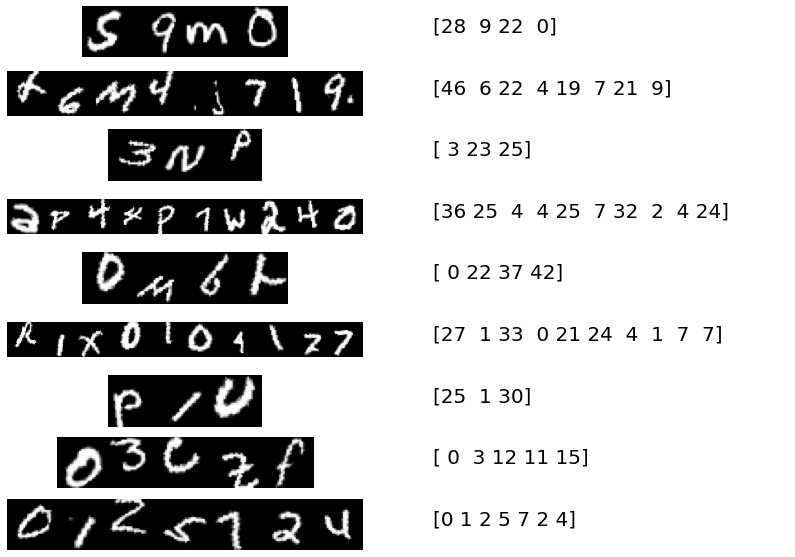

In [5]:
print('The train set has {} samples.'.format(len(trainset)))
print('The test set has {} samples.'.format(len(testset)))
num_plotted_samples = 9
fig, axs = plt.subplots(num_plotted_samples, 2,figsize=(14, 10))
for ind in range(num_plotted_samples): 
    img, label = trainset[ind]
    axs[ind,0].imshow(img.squeeze().numpy(), cmap='Greys_r')
    axs[ind,1].text(0,.5,str(label.numpy()), fontsize=20)
    axs[ind,0].axis('off')
    axs[ind,1].axis('off')

Until now, our models admited different lengths sequences (the goal was to reduce computation cost when doing the forward and backward pass with images smaller than maximun length (in our case 10 labels)). If we want to apply Spatial Transformer Networks, where the localisation network output $\theta$ dependes on the fixed size of the input images. In this case, our model input shoud have the same size. In our case, 28x280 pixels.

In [ ]:
class Basic_CNN_STN(nn.Module):
    def __init__(self,height,nlabels,prob): #Nlabels will be 47 in our case
        super().__init__()
        
        self.height = height
        self.nlabels = nlabels
        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=3, stride=1, padding=1)
        
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        
        self.conv3 = nn.Conv2d(16, 32, 7, stride=7, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(32,256)
        
        self.linear2 = nn.Linear(256, nlabels)
    
        self.activation = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 

        self.BN_1 = nn.BatchNorm2d(num_features=6)

        self.BN_2 = nn.BatchNorm2d(num_features=16)
        
        self.BN_3 = nn.BatchNorm2d(num_features=32)

        self.BN_4 = nn.BatchNorm1d(256)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=prob)
        
        self.localization = nn.Sequential(
                nn.Conv2d(1, 8, kernel_size=3, padding=1),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(True),
                nn.Conv2d(8, 10, kernel_size=3, padding=1),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(True),
                nn.Conv2d(10, 10, kernel_size=3, padding=1),
                nn.MaxPool2d(7 , stride=7),
                nn.ReLU(True),
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 1 * 10, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 1 * 10)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        input_width = x.shape[3]
        # transform the input
        x = self.stn(x)
        x = self.conv1(x) 
        x = self.BN_1(x)
        x = self.activation(x) 
        x = self.pool(x)
        x = self.dropout(x) 
        x = self.conv2(x)
        x = self.BN_2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.dropout(x) 
        x = self.conv3(x)
        x = self.BN_3(x)
        x = self.activation(x)
        x = self.dropout(x)
        # Pass the tensor through the Dense Layers
        x = x.squeeze(2)
        x = x.transpose(1,2)
        x = x.reshape(-1,32)
        x = self.linear1(x)
        x = self.BN_4(x)
        x = self.activation(x)
        x = self.dropout(x) 
        x = self.linear2(x)
        output_width = int(input_width/self.height)
        x = x.view(-1,output_width, self.nlabels)
        x = x.transpose(1,2)
        x = self.logsoftmax(x) 
        return x

In [6]:
stn_model = htrModels.Basic_CNN_STN(height=28, nlabels=47,prob=0)

For sequences, could be a good idea to implement [Long Short-Term Memory Spatial Transformer Network](https://arxiv.org/pdf/1901.02273.pdf).

In [ ]:
eval_performance(stn_model, testloader)

In [ ]:
with torch.no_grad():
    img, label, width, length = next(iter(demoloader))
    probs = stn_model.forward(img)
    top_p, top_class = probs.topk(1, dim=1)
    top_class[0]
    procesed_img = stn_model.stn(img)
    f, axarr = plt.subplots(2, 1)
    axarr[0].imshow(img[2].squeeze().numpy(), cmap='Greys_r')
    axarr[0].set_title('Dataset Images')

    axarr[1].imshow(procesed_img[2][1].squeeze().numpy(), cmap='Greys_r')
    axarr[1].set_title('Transformed Images')
